In [1]:
import pandas as pd
import geopandas as gpd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 99

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1088658/3115554905.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Radios Censales en Departamentos IGN - Reconciliación de Información Geográfica

**Reconciliación de Información Geográfica**

El objetivo principal de esta notebook es conciliar información geográfica. En particular, se busca ajustar las geometrías de los radios censales del CONICET para que coincidan con las áreas geográficas del IGN.

Para lograr esto, se realiza una intersección espacial entre los radios censales del CONICET que necesitan ser ubicados espacialmente (por problemas de falta de datos, cambios en limites de departamentos, u otras anomalias) y las geometrías del IGN. Este proceso implica superponer las geometrías de ambas fuentes espacialmente y encontrar las áreas en las que se cruzan. Luego, para cada radio censal, se selecciona el departamento del IGN con el que tiene la mayor intersección.

En el caso de la Ciudad Autónoma de Buenos Aires (CABA), se realizan algunos ajustes adicionales debido a los cambios en la división administrativa de la ciudad en el año 2010. En particular, se ajustan los códigos de las comunas de la CABA para que coincidan con los códigos utilizados por el INDEC.

Además, se proporcionan gráficos para visualizar las subdivisiones de los distritos que se realizaron durante este proceso.

In [2]:
### Algoritmo

# Cargar base de datos y mergear por codigo
# (Deptos en Base del Censo son los mismo que tiene Rodriguez?)

# lo que no esta OK o no coincide codigo va todo a compararse en spatial join

# Se concatenan resultados

Almacenamiento de los Datos Procesados

Los datos procesados, que ahora contienen información geográfica conciliada de ambas fuentes, se almacenan en un archivo shapefile para su uso posterior. Este archivo se guarda con el nombre radios_IGN_<year>, donde <year> es el año del censo.

Almacenamiento de los datos procesados: `CONICET_radios_IGN.to_file('radios_IGN_'+year)`

Con estos archivos de shapefile, podes realizar análisis geoespaciales precisos y coherentes en cada uno los puntos de la Argentina.

In [3]:
year = '2010'

### Codigos de Fracciones segun base de datos

In [4]:
path_ = './censos_db_ref/'+year

if year == '1991':
    censo = pd.read_csv(path_ + '/FRACCION.csv', ';'
                       ).merge(pd.read_csv(path_ + '/DEPTO.csv', ';')
                             ).merge(pd.read_csv(path_ + '/PROVIN.csv', ';'))
    censo = censo.rename(columns = {'PROVIN': 'IDPROV', 'DEPTO': 'IDDPTO', 'FRACCION': 'IDFRAC', 'RADIO': 'IDRADIO'})
    
else:
    censo = pd.read_csv(path_ + '/FRAC.csv', sep = ';'
                  ).merge(pd.read_csv(path_ + '/DPTO.csv', sep = ';')
                         ).merge(pd.read_csv(path_ + '/PROV.csv', sep = ';'))
    
# df['COD_1991'] = df['IDPROV'].astype(str).str.zfill(2) + df['IDDPTO'].astype(str).str.zfill(3) \
# + df['IDFRAC'].astype(str).str.zfill(2) + df['IDRADIO'].astype(str).str.zfill(2)

## Este df tiene Antartida e Islas, que en el archivo de Rodriguez no estan.
# 94021 Antártida Argentina, 94028 Islas del Atlántico Sur
# Se mergean por codigo, igual...

# # Excluyo CABA, en censos1991, 2001
# censo = censo.loc[censo.PROV != 2]

## Adapto columnas para mergear
censo['PROV_'] = censo.IDPROV.astype(str).str.zfill(2)
censo['DEPTO_'] = censo.IDDPTO.astype(str).str.zfill(3)
censo['FRACC_'] = censo.IDFRAC.astype(str).str.zfill(2)

### Informacion espacial en Censo (2010)

In [5]:
## Solo para el CRS:
dptos_censo_shp = gpd.read_file('./censos_shp_CONICET_dissolved/dptos_'+year+'.shp')
CONICET_INDEC_crs = dptos_censo_shp.crs

In [12]:
IGN = gpd.read_file('./../geoespacial-censo-IGN/IGN_shp/ign_departamento')[['IN1', 'NAM', 'geometry']]

In [23]:
# # Check the CRS of each GeoDataFrame
# print(CONICET_INDEC.crs)
# print(IGN.crs)

# Reproject one of the GeoDataFrames to the CRS of the other GeoDataFrame
CONICET_INDEC_reprojected = dptos_censo_shp.to_crs(IGN.crs)

# Now both GeoDataFrames have the same CRS and can be used for overlay
result = gpd.overlay(CONICET_INDEC_reprojected, IGN, how='intersection')

In [27]:
result['area_km2'] = result.area.astype(float)

# Group by 'PROV_' and 'DEPTO_' and get the indices of the largest area for each group
idx_max_area = result.groupby(['PROV_', 'DEPTO_'])['area_km2'].idxmax()

# Select the corresponding rows containing the 'IN1' and 'NAM' values
largest_area_info = result.loc[idx_max_area, ['PROV_', 'DEPTO_', 'IN1', 'NAM', 'geometry', 'area_km2']]

largest_area_info

,PROV_,DEPTO_,IN1,NAM,geometry,area_km2
0,02,001,02007,Comuna 1,"POLYGON Z ((-58.39154 -34.58087 0.00000, -58.39154 -34.58087 0.00000, -58.39159 -34.58085 0.000...",0.001742
10,02,002,02014,Comuna 2,"POLYGON Z ((-58.40451 -34.59804 0.00000, -58.40473 -34.59804 0.00000, -58.40559 -34.59805 0.000...",0.000615
16,02,003,02021,Comuna 3,"POLYGON Z ((-58.39991 -34.62857 0.00000, -58.39991 -34.62857 0.00000, -58.40085 -34.62867 0.000...",0.000627
4,02,004,02028,Comuna 4,"MULTIPOLYGON Z (((-58.35579 -34.61814 0.00000, -58.35553 -34.61872 0.00000, -58.35539 -34.61903...",0.002131
26,02,005,02035,Comuna 5,"POLYGON Z ((-58.42926 -34.61512 0.00000, -58.43000 -34.61544 0.00000, -58.43005 -34.61403 0.000...",0.000654
...,...,...,...,...,...,...
3117,90,105,90105,Tafí Viejo,"POLYGON Z ((-65.26856 -26.74930 0.00000, -65.26933 -26.74916 0.00000, -65.26933 -26.74916 0.000...",0.100359
2800,90,112,90112,Trancas,"POLYGON Z ((-65.22598 -26.56900 0.00000, -65.22598 -26.56901 0.00000, -65.22598 -26.56901 0.000...",0.271123
3141,90,119,90119,Yerba Buena,"POLYGON Z ((-65.29101 -26.83236 0.00000, -65.29101 -26.83236 0.00000, -65.29101 -26.83236 0.000...",0.012434
3144,94,007,94007,Río Grande,"POLYGON Z ((-68.60773 -54.13462 0.00000, -68.60773 -54.13462 0.00000, -68.60773 -54.13462 0.000...",0.892548


In [29]:
largest_area_info.to_file('./info/censo10_IGN_ref.geojson', driver = 'GeoJSON')

### Referencia IGN

In [ ]:
import geopandas as gpd

In [ ]:
ref_ = gpd.read_file('./IGN_shp/ign_departamento/')
ref_.loc[ref_.IN1 == '60441', 'IN1'] = '06441'   # Error en el codigo de area de La Plata
ref_ = ref_.loc[~ref_.IN1.isin(['94028', '94021'])] # Excluir Antartida e Islas
ref_ = ref_.to_crs(dptos_censo_shp.crs)
# ref_['PROV_'] = ref_['IN1'].str[:2]
# ref_['DEPTO_'] = ref_['IN1'].str[2:]  # Esto esta 'mal', porque IN1 actualizo codigos. Pero justamente vamos a querer ver cuando DEPTO_ segun IGN no coincide con DEPTO_ en Censo

In [ ]:
ref_provs = gpd.read_file('./IGN_shp/Provincia/')
ref_provs = ref_provs.to_crs(dptos_censo_shp.crs)
ref_provs['PROV_'] = ref_provs['IN1']

ref_provs.head(2)

,OBJECTID,Entidad,Objeto,FNA,GNA,NAM,SAG,FDC,IN1,SHAPE_STAr,SHAPE_STLe,geometry,PROV_
0,427,0,Provincia,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma,Ciudad Autónoma de Buenos Aires,IGN,Geografía,02,0.020242,0.743806,"POLYGON Z ((4202961.955 6141505.576 0.000, 4202913.501 6141488.854 0.000, 4202775.012 6141441.0...",02
1,428,0,Provincia,Provincia del Neuquén,Provincia,Neuquén,IGN,Geografía,58,9.771811,21.515985,"POLYGON Z ((3104529.599 5990240.027 0.000, 3104571.120 5989730.595 0.000, 3104581.804 5989403.3...",58


## Unir IGN y Censo

In [ ]:
### Marcar Manual para tener crossw ref
import pandas as pd
df = pd.read_csv('./info.csv', dtype = str); 
df['PROV_'] = df['PROV_'].str.zfill(2); df['DEPTO_'] = df['DEPTO_'].str.zfill(3)

if year == '1991': 
    nam_ref = censo[['PROV_', 'DEPTO_', 'NOMBPROV', 'NOMBDEPTO']].drop_duplicates()
elif year == '2001':
    nam_ref = censo[['PROV_', 'DEPTO_', 'NOMPROV', 'NOMDEPTO']].drop_duplicates()
elif year == '2010':
    nam_ref = censo[['PROV_', 'DEPTO_', 'NOMPROV', 'NOMDPTO']].drop_duplicates()
    
CABA = nam_ref.loc[nam_ref.PROV_ == '02']

out = df.merge(nam_ref, how = 'left').dropna()

if year != '2010':
    out = pd.concat([out, CABA]).sort_values(['PROV_', 'DEPTO_'])
    
if year == '1991': 
    out = out[['PROV_', 'NOMBPROV', 'DEPTO_', 'NOMBDEPTO']]
elif year == '2001':
    out = out[['PROV_', 'NOMPROV', 'DEPTO_', 'NOMDEPTO']]
elif year == '2010':
    out = out[['PROV_', 'NOMPROV', 'DEPTO_', 'NOMDPTO']]
    
out = out.drop_duplicates()
out.to_csv('./crosw_INDEC_'+year+'.csv', index = False)
out

##########################

df = pd.read_csv('./info_IGN.csv', dtype = str)
df['IN1'] = df['IN1'].str.zfill(5)

CABA = ref_.loc[ref_.IN1.str[:2] == '02'][df.columns]

if year != '2010':
    df = pd.concat([df, CABA]).sort_values(['IN1'])
    
out = df.drop_duplicates()
out.to_csv('./crosw_IGN_'+year+'.csv', index = False)
out

,IN1,NAM
0,06134,Cañuelas
1,06218,Chascomús
2,06466,Lezama
3,06260,Esteban Echeverría
4,06270,Ezeiza
5,06648,Presidente Perón
6,06274,Florencio Varela
7,06412,José C. Paz
8,06515,Malvinas Argentinas
9,06638,Pilar


In [ ]:
### Tengo cierta informacion.
dptos_join_censo = gpd.GeoDataFrame(pd.read_csv('./crosw_INDEC_'+year+'.csv', dtype = str).merge(dptos_censo_shp)[['PROV_','DEPTO_', 'geometry']])
dptos_join_IGN = gpd.GeoDataFrame(pd.read_csv('./crosw_IGN_'+year+'.csv', dtype = str).merge(ref_)[['IN1', 'NAM', 'geometry']])

## Acordarse del codigo de partido de la plata, ademas de los codigos de CABA, que fueron cambiados.

In [ ]:
## Intersecciones entre los deptos en censo que han cambiado (ej. Chascomus) y los deptos en IGN que no aparecieron en censo (Ej. el 'nuevo' Chascomus y  Lezama)
crossw_geo = gpd.overlay(dptos_join_censo, dptos_join_IGN, how='intersection')

In [ ]:
# Ejemplo, antiguos distritos escolares a Comunas
from shapely.geometry import box
import matplotlib.pyplot as plt
%matplotlib inline

if year != '2010':
    fig, ax = plt.subplots(1, figsize = (7, 7))

    CABA = crossw_geo.loc[crossw_geo.PROV_ == '02']
    CABA.dissolve('DEPTO_').plot(color = 'None', edgecolor = 'r', ax = ax, lw = .5)
    CABA.dissolve('IN1').plot(color = 'None', edgecolor = 'g', ax = ax, lw = .5)

    # plot bounds
    x0, y0, x1, y1 = box(*CABA.total_bounds).buffer(2000).bounds  ## 2km alrededor de CABA
    # minx, miny, maxx, maxy

    ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
    ax.axis('off')

    plt.show()


In [ ]:
## Ahora, hacer la interseccion espacial entre cada deptos del censo con los de IGN.
CONICET_radios = gpd.read_file('./censos_shp_CONICET/'+year+'_RADIOS ARGENTINA/')[['PROV_','DEPTO_', 'FRACC_', 'COD_'+year, 'geometry']]

## El archivo de rodriguez de 2010 tiene un problemita por el cual los codigos de deptos de la provincia de Formosa fueron sobreescritos con los codigos de fracciones. 
# Para constatar que afecta solamente a todas las entradas de formosa (PROV 34)
# (CONICET_radios['COD_2010'].str[2:5] == CONICET_radios.DEPTO_).groupby(CONICET_radios.PROV_).sum()/CONICET_radios.groupby(CONICET_radios.PROV_).size()
if year == '2010':    # Lo corregimos
    CONICET_radios['DEPTO_'] = CONICET_radios['COD_2010'].str[2:5]


CONICET_radios['DEPTO_'] = CONICET_radios['DEPTO_'].str.zfill(3)
CONICET_radios['geometry'] = CONICET_radios['geometry'].buffer(1) # Un metro de buffer para garantizar que no queden marcas entre radios

## De un lado los radios a ubicar, aquellos en los deptos viejos (y en CABA previo a las comunas).
radios_ubicar = gpd.GeoDataFrame(dptos_join_censo[['PROV_','DEPTO_']].drop_duplicates().merge(CONICET_radios))

In [ ]:
radios_ubicar.head()

,PROV_,DEPTO_,FRACC_,COD_2010,geometry
0,06,217,02,062170204,"POLYGON ((4224012.353 6061064.263, 4224012.432 6061064.323, 4224012.517 6061064.376, 4224012.60..."
1,06,217,02,062170201,"POLYGON ((4223584.309 6060701.223, 4223584.383 6060701.287, 4223584.463 6060701.344, 4223584.54..."
2,06,217,02,062170205,"POLYGON ((4235934.308 6054808.722, 4235934.382 6054808.786, 4235934.461 6054808.842, 4235934.54..."
3,06,217,02,062170203,"POLYGON ((4223423.521 6048031.297, 4223423.505 6048031.399, 4223423.500 6048031.501, 4223423.50..."
4,06,217,02,062170206,"POLYGON ((4232058.272 6043513.314, 4232058.239 6043513.351, 4231000.739 6044752.351, 4231000.68..."


In [ ]:
## Intersectar los radios en cuestion con los polis de IGS.
inters = gpd.overlay(radios_ubicar, dptos_join_IGN[['IN1', 'geometry']], how='intersection')
inters['area'] = inters.area

# Quedarse con el que mas interseca (el radio se asigna al depto donde este mayor parte de su area.)
radios_in_depto = inters.groupby(['PROV_', 'DEPTO_', 'COD_'+year]).apply(lambda x: x.nlargest(1, 'area')).reset_index(drop = True)[['PROV_', 'DEPTO_', 'COD_'+year, 'IN1']]
radios_in_depto['FRACC_'] = radios_in_depto['COD_'+year].str[5:7]


In [ ]:
## Test: se perdio algun radio? Puede pasar por algunos detalles de proyeccion
if not radios_in_depto['COD_'+year].nunique() == radios_ubicar['COD_'+year].nunique():
    print('Hubo radios sin interseccion')

Hubo radios sin interseccion


In [ ]:
radios_in_depto.head()

,PROV_,DEPTO_,COD_2010,IN1,FRACC_
0,06,217,062170101,06218,01
1,06,217,062170102,06218,01
2,06,217,062170103,06218,01
3,06,217,062170104,06218,01
4,06,217,062170105,06218,01


In [ ]:
radios_in_depto.nunique()

PROV_         2
DEPTO_        3
COD_2010    117
IN1           3
FRACC_       12
dtype: int64

In [ ]:
CONICET_radios_IGN = CONICET_radios.merge(radios_in_depto, how = 'left')

CONICET_radios_IGN['IN1'] = CONICET_radios_IGN.PROV_ + CONICET_radios_IGN.DEPTO_

# in 2010, CABA esta en comunas, pero los codigos de IGN no son los mismos que usa INDEC.
##  (Son los mismos pero multiplicados por 7.)
# ref_.loc[ref_.IN1.str[:2] == '02'].sort_values('IN1')

if year == '2010':
    CONICET_radios_IGN.loc[CONICET_radios_IGN.PROV_ == '02', 'IN1'] = CONICET_radios_IGN.loc[CONICET_radios_IGN.PROV_ == '02', 'PROV_'] + (7 * CONICET_radios_IGN.loc[CONICET_radios_IGN.PROV_ == '02', 'IN1'].astype(int)).astype(str).str.zfill(3)

In [ ]:
CONICET_radios_IGN.head()

,PROV_,DEPTO_,FRACC_,COD_2010,geometry,IN1
0,02,013,03,020130302,"POLYGON ((4192221.072 6153090.127, 4192221.041 6153090.218, 4192221.018 6153090.312, 4192221.00...",0214091
1,02,013,11,020131101,"POLYGON ((4193004.845 6152773.755, 4193004.922 6152773.816, 4193005.004 6152773.869, 4193005.09...",0214091
2,02,013,01,020130104,"POLYGON ((4192183.810 6152816.117, 4192157.781 6152917.752, 4192157.779 6152917.761, 4192148.76...",0214091
3,02,013,01,020130103,"POLYGON ((4192119.388 6153045.932, 4192119.483 6153045.964, 4192119.582 6153045.986, 4192119.68...",0214091
4,02,013,01,020130102,"POLYGON ((4191714.098 6152866.569, 4191714.059 6152866.661, 4191714.030 6152866.757, 4191714.01...",0214091


In [ ]:
## Chequeo por cambios de codigo

s1 = set(CONICET_radios_IGN.IN1.unique())
s2 = set(ref_.IN1.unique())

s2 - s1 # estan en IGN y no en conicet

display(ref_[['IN1', 'NAM']].loc[ref_.IN1.isin(s2 - s1)].sort_values('IN1'))

s1 - s2 ## Estan en conicet y no en IGN

check = censo[['PROV_', 'DEPTO_', 'NOMDPTO']].drop_duplicates()
display(check.loc[(check.PROV_ + check.DEPTO_).isin(s1 - s2)])

,IN1,NAM
124,02007,Comuna 1
204,02014,Comuna 2
243,02021,Comuna 3
125,02028,Comuna 4
126,02035,Comuna 5
82,02042,Comuna 6
127,02049,Comuna 7
205,02056,Comuna 8
390,02063,Comuna 9
128,02070,Comuna 10


,PROV_,DEPTO_,NOMDPTO
1431,06,217,Chascomús


In [ ]:
CONICET_radios_IGN.nunique()

PROV_          24
DEPTO_        154
FRACC_         99
COD_2010    52401
geometry    52401
IN1           525
dtype: int64

In [ ]:
## Aca el archivo definitivo que tiene los radios censales en los deptos IGN. CON GEOMETRIAS!

In [ ]:
CONICET_radios_IGN.to_file('radios_IGN_'+year)

## Mapas de los distritos que fueron subdivididos

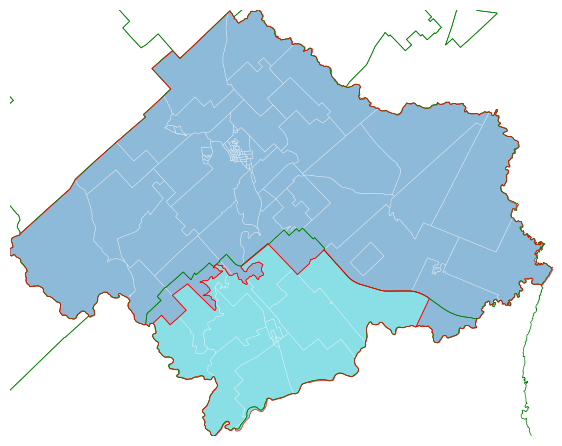

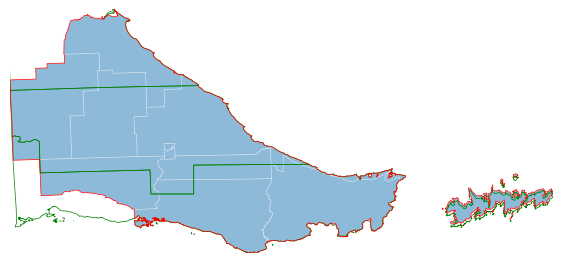

In [ ]:

for i, row in crossw_geo[['PROV_']].drop_duplicates().iterrows():
    rads = radios_in_depto.loc[(radios_in_depto.PROV_ == row.PROV_)]
    rads_gdf = gpd.GeoDataFrame(rads.merge(CONICET_radios[['COD_'+year, 'geometry']]))
    
    fig, ax = plt.subplots(1, figsize = (7, 7))
    
    rads_gdf.plot('IN1', ax = ax, alpha = .5, edgecolor = 'w', lw = .4)
    
    ref_.loc[ref_.IN1.str[:2] == row.PROV_].plot(color = 'None', edgecolor = 'g', ax = ax, lw = .5)

    limits = gpd.GeoDataFrame(rads.merge(CONICET_radios[['COD_'+year, 'geometry']])).dissolve('IN1')
    limits.plot(color = 'None', edgecolor = 'r', ax = ax, lw = .5)
    
    # plot bounds
    x0, y0, x1, y1 = rads_gdf.total_bounds # minx, miny, maxx, maxy
    ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
    ax.axis('off')

    plt.show()